In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

from transformers import pipeline

from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

In [ ]:
# check if CUDA GPU is available
device = 0 if torch.cuda.is_available() else -1

In [ ]:
# load toxicity annotation model
toxpipe = pipeline("text-classification", model="cooperleong00/deberta-v3-large_toxicity-scorer", device=device)

## Wiki-Detox

In [ ]:
# read in original data
df = pd.read_csv('../data/wiki-detox/original_detox.tsv',sep='\t')

# read in dialect subsets
aave = pd.read_json("../data/wiki-detox/aave_1k.jsonl", lines=True)
nigerianD = pd.read_json("../data/wiki-detox/nigerianD_1k.jsonl", lines=True)
indianD = pd.read_json("../data/wiki-detox/indianD_1k.jsonl", lines=True)
singlish = pd.read_json("../data/wiki-detox/singlish_1k.jsonl", lines=True)

# get the first 1000 toxicity scores in dfa for development
df_sample = df.iloc[:1000]

### run DeBERTa toxicity scorer on the original texts and all 4 dialects

In [ ]:
def get_label_confidence(sents):
    label_confidence = []  # list of tuple
    for sent in tqdm(sents):
        result = toxpipe(sent)[0]

        # confidence: numerical score of toxicity rating: (-1 ~ 1)
        if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
            label = 1  # 1: toxic == true
            confidence = -result["score"]
        else:
            label = 0  # 0: toxic == false
            confidence = result["score"]

        res = [label, confidence]
        label_confidence.append(res)

    # convert results to a dataframe with labels
    lconf = pd.DataFrame(label_confidence, columns =['label', 'confidence'], dtype = float)

    return lconf

In [ ]:
lconf_og_1k = get_label_confidence(df["comment"][:1000])
lconf_og_1k.to_csv("../data/wiki-detox/lconf_original_1k.csv", sep=",", index=False)

lconf_aave_1k = get_label_confidence(aave["text"])
lconf_aave_1k.to_csv("../data/wiki-detox/lconf_aave_1k.csv", sep=",", index=False)

lconf_nigerianD_1k = get_label_confidence(nigerianD["text"])
lconf_nigerianD_1k.to_csv("../data/wiki-detox/lconf_nigerianD_1k.csv", sep=",", index=False)

lconf_indianD_1k = get_label_confidence(indianD["text"])
lconf_indianD_1k.to_csv("../data/wiki-detox/lconf_indianD_1k.csv", sep=",", index=False)

lconf_singlish_1k = get_label_confidence(singlish["text"])
lconf_singlish_1k.to_csv("../data/wiki-detox/lconf_singlish_1k.csv", sep=",", index=False)

100%|██████████| 1000/1000 [15:09<00:00,  1.10it/s] 


### check results on Wiki-Detox

In [ ]:
# load saved predictions and check distribution of labels
lconf_og_1k = pd.read_csv("../data/wiki-detox/lconf_original_1k.csv")
lconf_aave_1k = pd.read_csv("../data/wiki-detox/lconf_aave_1k.csv")
lconf_nigerianD_1k = pd.read_csv("../data/wiki-detox/lconf_nigerianD_1k.csv")
lconf_indianD_1k = pd.read_csv("../data/wiki-detox/lconf_indianD_1k.csv")
lconf_singlish_1k = pd.read_csv("../data/wiki-detox/lconf_singlish_1k.csv")

print(Counter(lconf_og_1k["label"]))
print(Counter(lconf_aave_1k["label"]))
print(Counter(lconf_nigerianD_1k["label"]))
print(Counter(lconf_indianD_1k["label"]))
print(Counter(lconf_singlish_1k["label"]))

Counter({0.0: 964, 1.0: 36})
Counter({0.0: 963, 1.0: 37})
Counter({0.0: 965, 1.0: 35})
Counter({0.0: 966, 1.0: 34})
Counter({0.0: 963, 1.0: 37})


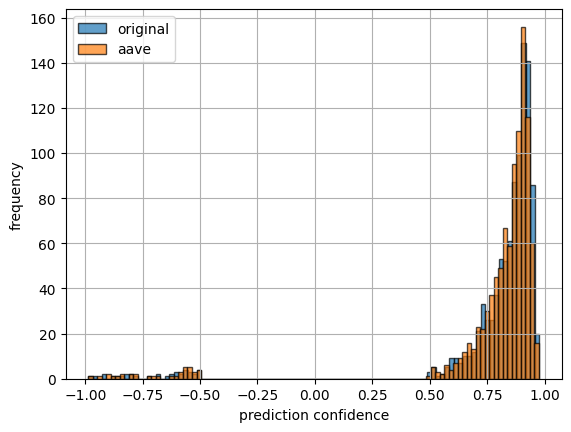

In [ ]:
plt.hist(lconf_og_1k["confidence"], bins=100, edgecolor='black', alpha=0.7, label="original")
plt.hist(lconf_aave_1k["confidence"], bins=100, edgecolor='black', alpha=0.7, label="aave")
plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# KS test for prediction confidence on Wiki-Detox
print("overall: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: KS test for prediction confidence original vs. dialects
Statistics=0.07200, p=0.01119
Statistics=0.05600, p=0.08690
Statistics=0.05400, p=0.10829
Statistics=0.10100, p=0.00007


In [ ]:
# Mann Whitney U test for prediction confidence on Wiki-Detox
print("overall: Mann Whitney U test for prediction confidence original vs. dialects")
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: Mann Whitney U test for prediction confidence original vs. dialects
Statistics=532991.00000, p=0.01063
Statistics=527190.50000, p=0.03524
Statistics=522656.00000, p=0.07935
Statistics=549670.50000, p=0.00012


In [ ]:
# overall prediction confidence
print("overall -----------------")
print(np.average([c for c in lconf_og_1k["confidence"]]))
print(np.average([c for c in lconf_aave_1k["confidence"]]))
print(np.average([c for c in lconf_nigerianD_1k["confidence"]]))
print(np.average([c for c in lconf_indianD_1k["confidence"]]))

# average confidence of toxic predictions
print("toxic -------------------")
print(np.average([abs(c) for c in lconf_og_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_aave_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_nigerianD_1k["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_indianD_1k["confidence"] if c < 0]))

# average confidence of non-toxic predictions
print("non-toxic ---------------")
print(np.average([abs(c) for c in lconf_og_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_aave_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_nigerianD_1k["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_indianD_1k["confidence"] if c > 0]))

overall -----------------
0.797173512518406
0.7897873908281327
0.7925030657052994
0.7966783827543259
toxic -------------------
0.6760093718767166
0.6629518866539001
0.671651726109641
0.6530748745974373
non-toxic ---------------
0.8521886409812943
0.8456039570449916
0.8456071255120589
0.8477048949178455


## Davidson's Twitter

In [ ]:
# read in original data
df = pd.read_csv('../data/davidson/original_davidson.csv', sep=',', index_col=0)

# read in dialect subsets
aave = pd.read_json("../data//davidson/aave_1k.jsonl", lines=True)
nigerianD = pd.read_json("../data//davidson/nigerianD_1k.jsonl", lines=True)
indianD = pd.read_json("../data//davidson/indianD_1k.jsonl", lines=True)
singlish = pd.read_json("../data//davidson/singlish_1k.jsonl", lines=True)

# get the first 1000 toxicity scores in dfa for development
df_sample = df.iloc[:1000]

In [ ]:
def get_label_confidence(sents):
    """functions for getting toxicity label and confidence score for a list of sentences"""
    label_confidence = []  # list of tuple
    for sent in tqdm(sents):
        result = toxpipe(sent)[0]

        # confidence: numerical score of toxicity rating: (-1 ~ 1)
        if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
            label = 1  # 1: toxic == true
            confidence = -result["score"]
        else:
            label = 0  # 0: toxic == false
            confidence = result["score"]

        res = [label, confidence]
        label_confidence.append(res)

    # convert results to a dataframe with labels
    lconf = pd.DataFrame(label_confidence, columns =['label', 'confidence'], dtype = float)

    return lconf

In [ ]:
lconf_og_1k = get_label_confidence(df_sample["tweet"][:1000])
lconf_og_1k.to_csv("../data/davidson/lconf_original_1k.csv", sep=",", index=False)

lconf_aave_1k = get_label_confidence(aave["text"])
lconf_aave_1k.to_csv("../data/davidson/lconf_aave_1k.csv", sep=",", index=False)

lconf_nigerianD_1k = get_label_confidence(nigerianD["text"])
lconf_nigerianD_1k.to_csv("../data/davidson/lconf_nigerianD_1k.csv", sep=",", index=False)

lconf_indianD_1k = get_label_confidence(indianD["text"])
lconf_indianD_1k.to_csv("../data/davidson/lconf_indianD_1k.csv", sep=",", index=False)

lconf_singlish_1k = get_label_confidence(singlish["text"])
lconf_singlish_1k.to_csv("../data/davidson/lconf_singlish_1k.csv", sep=",", index=False)

100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]


### check results on Davidson's Twitter

In [ ]:
# load saved predictions and check distribution of labels
lconf_og_1k = pd.read_csv("../data/davidson/lconf_original_1k.csv")
lconf_aave_1k = pd.read_csv("../data/davidson/lconf_aave_1k.csv")
lconf_nigerianD_1k = pd.read_csv("../data/davidson/lconf_nigerianD_1k.csv")
lconf_indianD_1k = pd.read_csv("../data/davidson/lconf_indianD_1k.csv")
lconf_singlish_1k = pd.read_csv("../data/davidson/lconf_singlish_1k.csv")

print(Counter(lconf_og_1k["label"]))
print(Counter(lconf_aave_1k["label"]))
print(Counter(lconf_nigerianD_1k["label"]))
print(Counter(lconf_indianD_1k["label"]))
print(Counter(lconf_singlish_1k["label"]))

Counter({1.0: 796, 0.0: 204})
Counter({1.0: 783, 0.0: 217})
Counter({1.0: 790, 0.0: 210})
Counter({1.0: 780, 0.0: 220})
Counter({1.0: 781, 0.0: 219})


In [ ]:
# KS test for prediction confidence on Davidson
print("overall: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: KS test for prediction confidence original vs. dialects
Statistics=0.05100, p=0.14836
Statistics=0.03900, p=0.43261
Statistics=0.07000, p=0.01487
Statistics=0.04500, p=0.26347


In [ ]:
# Mann Whitney U test for prediction confidence on Davidson
print("overall: Mann Whitney U test for prediction confidence original vs. dialects")
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_aave_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_nigerianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_indianD_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_1k["confidence"]], [abs(c) for c in lconf_singlish_1k["confidence"]])
print('Statistics=%.5f, p=%.5f' % (stat, p))

overall: Mann Whitney U test for prediction confidence original vs. dialects
Statistics=518620.00000, p=0.14933
Statistics=515604.00000, p=0.22692
Statistics=529029.00000, p=0.02458
Statistics=513923.50000, p=0.28094


## HateXplain Twitter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read in original data
df = pd.read_json(f"../data/hatexplain/original_hatexplain.json").transpose()

# read in dialect subsets
aave = pd.read_json("../data/hatexplain/aave_full.jsonl", lines=True)
nigerianD = pd.read_json("../data/hatexplain/nigerianD_full.jsonl", lines=True)
indianD = pd.read_json("../data/hatexplain/indianD_full.jsonl", lines=True)
singlish = pd.read_json("../data/hatexplain/singlish_full.jsonl", lines=True)

# get the first 1000 toxicity scores in dfa for development
df_sample = df.iloc[:1000]

In [ ]:
def get_label_confidence(sents):
    label_confidence = []  # list of tuple
    for sent in tqdm(sents):
        result = toxpipe(sent)[0]

        # confidence: numerical score of toxicity rating: (-1 ~ 1)
        if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
            label = 1  # 1: toxic == true
            confidence = -result["score"]
        else:
            label = 0  # 0: toxic == false
            confidence = result["score"]

        res = [label, confidence]
        label_confidence.append(res)

    # convert results to a dataframe with labels
    lconf = pd.DataFrame(label_confidence, columns =['label', 'confidence'], dtype = float)

    return lconf

In [ ]:
# sample_tweets = [" ".join(token_ls) for token_ls in list(df_sample["post_tokens"])]
# lconf_og_1k = get_label_confidence(sample_tweets)
# lconf_og_1k.to_csv("../data/hatexplain/lconf_original_1k.csv", sep=",", index=False)
#
# lconf_aave_1k = get_label_confidence(aave["text"])
# lconf_aave_1k.to_csv("../data/hatexplain/lconf_aave_1k.csv", sep=",", index=False)
#
# lconf_nigerianD_1k = get_label_confidence(nigerianD["text"])
# lconf_nigerianD_1k.to_csv("../data/hatexplain/lconf_nigerianD_1k.csv", sep=",", index=False)
#
# lconf_indianD_1k = get_label_confidence(indianD["text"])
# lconf_indianD_1k.to_csv("../data/hatexplain/lconf_indianD_1k.csv", sep=",", index=False)
#
# lconf_singlish_1k = get_label_confidence(singlish["text"])
# lconf_singlish_1k.to_csv("../data/hatexplain/lconf_singlish_1k.csv", sep=",", index=False)

In [35]:
# df = pd.read_json(f"/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/original_hatexplain.json").transpose()

sample_tweets = [" ".join(token_ls) for token_ls in list(df["post_tokens"])]
lconf_og_full = get_label_confidence(sample_tweets)
lconf_og_full.to_csv("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/lconf_original_full.csv", sep=",", index=False)

In [33]:
# aave = pd.read_json("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/aave_full.jsonl", lines=True)

lconf_aave_full = get_label_confidence(aave["text"])
lconf_aave_full.to_csv("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/lconf_aave_full.csv", sep=",", index=False)

In [24]:
# nigerianD = pd.read_json("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/nigerianD_full.jsonl", lines=True)

lconf_nigerianD_full = get_label_confidence(nigerianD["text"])
lconf_nigerianD_full.to_csv("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/lconf_nigerianD_full.csv", sep=",", index=False)

In [29]:
# indianD = pd.read_json("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/indianD_full.jsonl", lines=True)

lconf_indianD_full = get_label_confidence(indianD["text"])
lconf_indianD_full.to_csv("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/lconf_indianD_full.csv", sep=",", index=False)

In [30]:
# singlish = pd.read_json("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/singlish_full.jsonl", lines=True)

lconf_singlish_full = get_label_confidence(singlish["text"])
lconf_singlish_full.to_csv("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/hatexplain/lconf_singlish_full.csv", sep=",", index=False)

### check results on HateXplain Twitter

In [2]:
# load saved predictions and check distribution of labels
lconf_og_full = pd.read_csv("../data/hatexplain/lconf_original_full.csv")
lconf_aave_full = pd.read_csv("../data/hatexplain/lconf_aave_full.csv")
lconf_nigerianD_full = pd.read_csv("../data/hatexplain/lconf_nigerianD_full.csv")
lconf_indianD_full = pd.read_csv("../data/hatexplain/lconf_indianD_full.csv")
lconf_singlish_full = pd.read_csv("../data/hatexplain/lconf_singlish_full.csv")

print(Counter(lconf_og_full["label"]))
print(Counter(lconf_aave_full["label"]))
print(Counter(lconf_nigerianD_full["label"]))
print(Counter(lconf_indianD_full["label"]))
print(Counter(lconf_singlish_full["label"]))

Counter({1.0: 15377, 0.0: 4771})
Counter({1.0: 15081, 0.0: 5067})
Counter({1.0: 15257, 0.0: 4891})
Counter({1.0: 14833, 0.0: 5315})
Counter({1.0: 15077, 0.0: 5071})


In [9]:
# # test if lconf_og_1k is normally distributed
# from scipy.stats import shapiro
# 
# stat, p = shapiro(lconf_og_full["confidence"])
# print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal
# 
# stat, p = shapiro(lconf_aave_full["confidence"])
# print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal
# stat, p = shapiro(lconf_nigerianD_full["confidence"])
# print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal
# stat, p = shapiro(lconf_indianD_full["confidence"])
# print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal
# stat, p = shapiro(lconf_singlish_full["confidence"])
# print('Statistics=%e, p=%e' % (stat, p)) # p < 0.05, not normal

In [6]:
# KS test for prediction confidence on Davidson
print("overall: KS test for prediction confidence original vs. dialects")
stat, p = ks_2samp([abs(c) for c in lconf_og_full["confidence"]], [abs(c) for c in lconf_aave_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_full["confidence"]], [abs(c) for c in lconf_nigerianD_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_full["confidence"]], [abs(c) for c in lconf_indianD_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_og_full["confidence"]], [abs(c) for c in lconf_singlish_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))

overall: KS test for prediction confidence original vs. dialects
Statistics=2.799285e-02, p=2.724284e-07
Statistics=2.178876e-02, p=1.381119e-04
Statistics=3.682748e-02, p=2.627361e-12
Statistics=2.010125e-02, p=5.746133e-04


In [5]:
# cross-dialect confidence differences (aave against other 3)
stat, p = ks_2samp([abs(c) for c in lconf_aave_full["confidence"]], [abs(c) for c in lconf_nigerianD_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_aave_full["confidence"]], [abs(c) for c in lconf_indianD_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = ks_2samp([abs(c) for c in lconf_aave_full["confidence"]], [abs(c) for c in lconf_singlish_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))

Statistics=9.330951e-03, p=3.421918e-01
Statistics=1.404606e-02, p=3.720377e-02
Statistics=1.131626e-02, p=1.503265e-01


In [12]:
# Mann Whitney U test for prediction confidence on Davidson
print("overall: Mann Whitney U test for prediction confidence original vs. dialects")
stat, p = mannwhitneyu([abs(c) for c in lconf_og_full["confidence"]], [abs(c) for c in lconf_aave_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_full["confidence"]], [abs(c) for c in lconf_nigerianD_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_full["confidence"]], [abs(c) for c in lconf_indianD_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))
stat, p = mannwhitneyu([abs(c) for c in lconf_og_full["confidence"]], [abs(c) for c in lconf_singlish_full["confidence"]])
print('Statistics=%e, p=%e' % (stat, p))

overall: Mann Whitney U test for prediction confidence original vs. dialects
Statistics=2.101440e+08, p=8.063761e-10
Statistics=2.086300e+08, p=1.253675e-06
Statistics=2.130052e+08, p=8.380298e-18
Statistics=2.081230e+08, p=1.021033e-05


In [13]:
# average confidence of toxic predictions
print("toxic -------------------")
print(np.average([abs(c) for c in lconf_og_full["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_aave_full["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_nigerianD_full["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_indianD_full["confidence"] if c < 0]))
print(np.average([abs(c) for c in lconf_singlish_full["confidence"] if c < 0]))

# average confidence of non-toxic predictions
print("non-toxic ---------------")
print(np.average([abs(c) for c in lconf_og_full["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_aave_full["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_nigerianD_full["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_indianD_full["confidence"] if c > 0]))
print(np.average([abs(c) for c in lconf_singlish_full["confidence"] if c > 0]))

toxic -------------------
0.8150816701700002
0.8075121585747804
0.8087509785558274
0.8050924247309192
0.8106455145752255
non-toxic ---------------
0.654921863157028
0.6523889296619949
0.6497493973175116
0.6518566252146817
0.6524585054320853


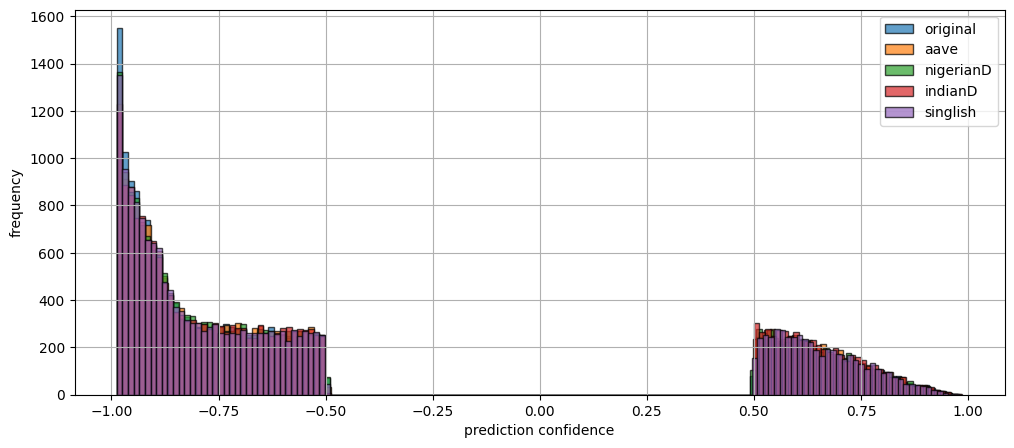

In [14]:
# plot prediction confidence of different dialects
plt.figure(figsize=(12, 5))

plt.hist(lconf_og_full["confidence"], bins=150, edgecolor='black', alpha=0.7, label="original")
plt.hist(lconf_aave_full["confidence"], bins=150, edgecolor='black', alpha=0.7, label="aave")
plt.hist(lconf_nigerianD_full["confidence"], bins=150, edgecolor='black', alpha=0.7, label="nigerianD")
plt.hist(lconf_indianD_full["confidence"], bins=150, edgecolor='black', alpha=0.7, label="indianD")
plt.hist(lconf_singlish_full["confidence"], bins=150, edgecolor='black', alpha=0.7, label="singlish")

plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()

# Twitter AAE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def get_sentences(file_path):
    sentences = []
    sentence = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.strip() == '':  # new sentence
                if sentence:  # if the list is not empty
                    sentences.append(sentence)
                    sentence = []
            else:
                columns = line.strip().split('\t')
                if len(columns) > 1:  # to ensure there is a second column
                    sentence.append(columns[1])  # append the word to the sentence

    # append the last sentence if it's not empty
    if sentence:
        sentences.append(sentence)

    return sentences

In [ ]:
sentences_aae = get_sentences("/content/drive/MyDrive/Colab Notebooks/data/aa250_gold.conllu")
sentences_wh = get_sentences("/content/drive/MyDrive/Colab Notebooks/data/wh250_gold.conllu")

In [ ]:
def get_label_confidence(sents):
    label_confidence = []  # list of tuple
    for sent in tqdm(sents):
        sent = " ".join(sent)
        result = toxpipe(sent)[0]

        # confidence: numerical score of toxicity rating: (-1 ~ 1)
        if result["label"] == "LABEL_1":  # convert score to negative if labeled as toxic
            label = 1  # 1: toxic == true
            confidence = -result["score"]
        else:
            label = 0  # 0: toxic == false
            confidence = result["score"]

        res = [label, confidence]
        label_confidence.append(res)

    # convert results to a dataframe with labels
    lconf = pd.DataFrame(label_confidence, columns =['label', 'confidence'], dtype = float)

    return lconf

In [ ]:
lconf_twitter_aae_aae = get_label_confidence(sentences_aae)
lconf_twitter_aae_aae.to_csv("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/twitter_aae_aae.csv", sep=",", index=False)

In [ ]:
lconf_twitter_aae_wh = get_label_confidence(sentences_wh)
lconf_twitter_aae_wh.to_csv("/content/drive/MyDrive/Colab Notebooks/CompMod_2324_BN-AP/data/twitter_aae_wh.csv", sep=",", index=False)

## check on lconf results

In [3]:
lconf_aae = pd.read_csv("../data/twitter_aae/lconf_aa250.csv")
lconf_wh = pd.read_csv("../data/twitter_aae/lconf_wh250.csv")
lconf_aave_synth = pd.read_csv("../data/twitter_aae/lconf_aave250_synthetic.csv")

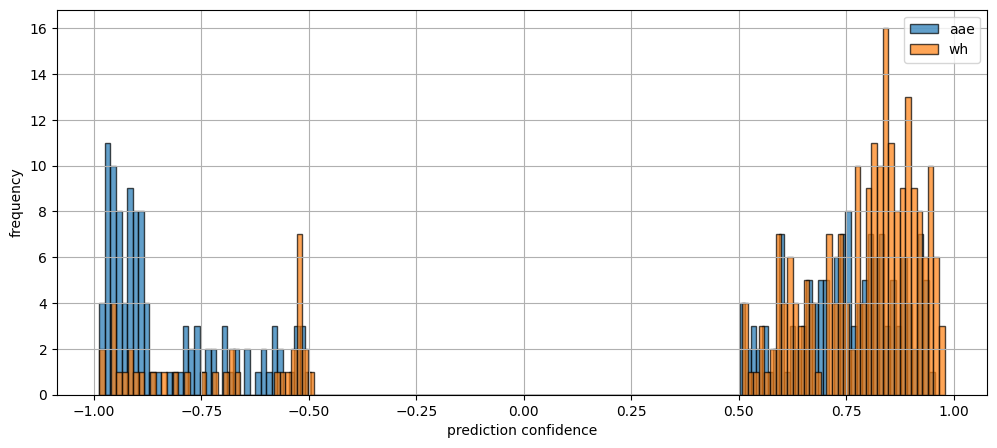

In [6]:
# plot prediction confidence of different dialects
plt.figure(figsize=(12, 5))

plt.hist(lconf_aae["confidence"], bins=150, edgecolor='black', alpha=0.7, label="aae")
plt.hist(lconf_wh["confidence"], bins=150, edgecolor='black', alpha=0.7, label="wh")

plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()

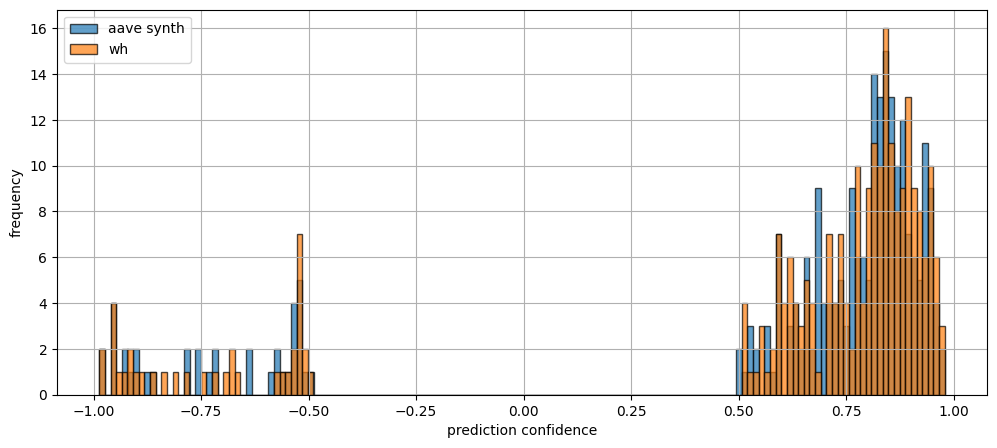

In [7]:
# plot prediction confidence of different dialects
plt.figure(figsize=(12, 5))

plt.hist(lconf_aave_synth["confidence"], bins=150, edgecolor='black', alpha=0.7, label="aave synth")
plt.hist(lconf_wh["confidence"], bins=150, edgecolor='black', alpha=0.7, label="wh")

plt.xlabel('prediction confidence')
plt.ylabel('frequency')
plt.legend()
plt.grid(True)
plt.show()